# 深度计算

目录

- 数值稳定性和模型初始化
- 层和块
- 参数管理
- 自定义层
- 读写文件
- GPU

## 数值稳定性和模型初始化

梯度消失

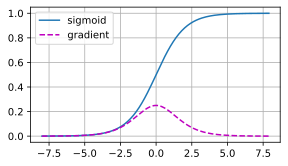

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

梯度爆炸

In [2]:
M = torch.normal(0, 1, size=(4,4))
print('一个矩阵 \n',M)
for i in range(100):
    M = torch.mm(M,torch.normal(0, 1, size=(4, 4)))

print('乘以100个矩阵后\n', M)

一个矩阵 
 tensor([[ 0.5039, -0.5113,  0.2666,  0.9192],
        [ 0.8290, -0.3719, -0.4758,  0.2095],
        [-2.8356,  1.5128,  3.2530,  1.2554],
        [-0.4369,  0.0571,  1.3445,  0.5465]])
乘以100个矩阵后
 tensor([[-2.6163e+27, -1.3641e+27,  3.7875e+26,  1.5981e+27],
        [ 9.2931e+25,  4.8452e+25, -1.3453e+25, -5.6765e+25],
        [-8.5595e+27, -4.4627e+27,  1.2391e+27,  5.2284e+27],
        [-3.1940e+27, -1.6653e+27,  4.6239e+26,  1.9510e+27]])


## 层和块

我们先回顾一下多层感知机

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

X = torch.rand(2, 20)
net(X)

tensor([[-0.0148, -0.0091, -0.1044, -0.0623,  0.1513,  0.0991,  0.1245, -0.1850,
          0.0858,  0.1818],
        [-0.0970,  0.0267,  0.0026, -0.0933, -0.0292,  0.1253,  0.2153, -0.0900,
          0.0387,  0.0119]], grad_fn=<AddmmBackward>)

`nn.Sequential`定义了一种特殊的`Module`

自定义块

In [2]:
class MLP(nn.Module):
    # 用模型参数声明层。这里，我们声明两个全连接的层
    def __init__(self):
        # 调用MLP的父类Module的构造函数来执行必要的初始化。
        # 这样，在类实例化时也可以指定其他函数参数，例如模型参数params（稍后将介绍）
        super().__init__()
        self.hidden = nn.Linear(20, 256)  # 隐藏层
        self.out = nn.Linear(256, 10)  # 输出层

    # 定义模型的前向传播，即如何根据输入X返回所需的模型输出
    def forward(self, X):
        # 注意，这里我们使用ReLU的函数版本，其在nn.functional模块中定义。
        return self.out(F.relu(self.hidden(X)))

实例化多层感知机的层，然后在每次调用前向传播函数时调用这些层

In [3]:
net = MLP()
net(X)

tensor([[ 0.2511,  0.1825,  0.0906, -0.1014, -0.0818, -0.2257,  0.0343, -0.0502,
         -0.1205,  0.1808],
        [ 0.0538,  0.2270, -0.0294, -0.0254,  0.0274, -0.1483, -0.1254,  0.0424,
         -0.1205,  0.1796]], grad_fn=<AddmmBackward>)

顺序块

In [ ]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # 这里，module是Module子类的一个实例。我们把它保存在'Module'类的成员
            # 变量_modules中。module的类型是OrderedDict
            self._modules[str(idx)] = module

    def forward(self, X):
        # OrderedDict保证了按照成员添加的顺序遍历它们
        for block in self._modules.values():
            X = block(X)
        return X

In [5]:
net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

tensor([[-0.0345,  0.0057,  0.0227, -0.1984, -0.2237, -0.0464, -0.0189, -0.2631,
         -0.2752, -0.1415],
        [-0.1851,  0.0243, -0.0286, -0.1372, -0.1288, -0.1205,  0.1659, -0.3036,
         -0.2170, -0.0545]], grad_fn=<AddmmBackward>)

在前向传播函数中执行代码

In [7]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # 不计算梯度的随机权重参数。因此其在训练期间保持不变
        self.rand_weight = torch.rand((20, 20), requires_grad=False)
        self.linear = nn.Linear(20, 20)

    def forward(self, X):
        X = self.linear(X)
        # 使用创建的常量参数以及relu和mm函数
        X = F.relu(torch.mm(X, self.rand_weight) + 1)
        # 复用全连接层。这相当于两个全连接层共享参数
        X = self.linear(X)
        # 控制流
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

net = FixedHiddenMLP()
net(X)

tensor(0.0362, grad_fn=<SumBackward0>)

混合搭配各种组合块的方法

In [8]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20, 64), nn.ReLU(),
                                 nn.Linear(64, 32), nn.ReLU())
        self.linear = nn.Linear(32, 16)

    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.Linear(16, 20), FixedHiddenMLP())
chimera(X)

tensor(-0.1137, grad_fn=<SumBackward0>)

## 参数管理

我们首先看一下具有单隐藏层的多层感知机

In [1]:
import torch
from torch import nn

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[-0.1909],
        [-0.2025]], grad_fn=<AddmmBackward>)

### 参数访问

In [2]:
print(net[2].state_dict())

OrderedDict([('weight', tensor([[-0.2358, -0.2256, -0.1930, -0.0475, -0.0732, -0.3483,  0.0520,  0.1466]])), ('bias', tensor([-0.0579]))])


### 目标参数

注意，每个参数都表示为参数类的一个实例。 要对参数执行任何操作，首先我们需要访问底层的数值。

In [3]:
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([-0.0579], requires_grad=True)
tensor([-0.0579])


In [4]:
net[2].weight.grad == None

True

### 一次性访问所有参数

In [5]:
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
print(*[(name, param.shape) for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


In [6]:
net.state_dict()['2.bias'].data

tensor([-0.0579])

### 从嵌套块收集参数

In [7]:
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                         nn.Linear(8, 4), nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        # 在这里嵌套
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)

tensor([[0.3983],
        [0.3983]], grad_fn=<AddmmBackward>)

设计了网络后，我们看看它是如何工作的

In [8]:
print(rgnet)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


通过嵌套列表索引访问

In [9]:
rgnet[0][1][0].bias.data

tensor([-0.3155,  0.0512,  0.3313,  0.2001, -0.2423, -0.2325, -0.4816, -0.0248])

### 内置初始化

In [10]:
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)
net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([ 0.0091,  0.0023, -0.0125,  0.0040]), tensor(0.))

In [11]:
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)
net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

对某些块应用不同的初始化方法

In [12]:
def xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)

net[0].apply(xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([ 0.5587,  0.2209, -0.0744,  0.3801])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


### 自定义初始化

In [13]:
def my_init(m):
    if type(m) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in m.named_parameters()][0])
        nn.init.uniform_(m.weight, -10, 10)
        m.weight.data *= m.weight.data.abs() >= 5 # |w| < 5 时清零

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[-8.4986,  0.0000, -0.0000, -0.0000],
        [ 6.7884,  0.0000, -9.8570, -6.8247]], grad_fn=<SliceBackward>)

直接设置参数

In [14]:
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.,  1.,  1.,  1.])

### 参数绑定

In [15]:
# 我们需要给共享层一个名称，以便可以引用它的参数
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(8, 1))
net(X)
# 检查参数是否相同
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# 确保它们实际上是同一个对象，而不只是有相同的值
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


思考：当参数绑定时，梯度会发生什么情况？

答案：由于模型参数包含梯度，因此在反向传播期间第二个隐藏层 （即第三个神经网络层）和第三个隐藏层（即第五个神经网络层）的梯度会加在一起。

## 自定义层

构造一个没有任何参数的自定义层

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn


class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return X - X.mean()

In [2]:
layer = CenteredLayer()
layer(torch.FloatTensor([1, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

将层作为组件合并到更复杂的模型中

In [4]:
net = nn.Sequential(nn.Linear(8, 128), CenteredLayer())

# 向该网络发送随机数据后，检查均值是否为0
Y = net(torch.rand(4, 8))
Y.mean()

tensor(2.6776e-09, grad_fn=<MeanBackward0>)

带参数的层

In [6]:
class MyLinear(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, units))
        self.bias = nn.Parameter(torch.randn(units,))
    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[-0.5454,  1.2766, -0.3547],
        [-0.4969, -0.2906, -0.9240],
        [ 0.2956, -0.8858,  1.3960],
        [-0.3093,  1.2917,  1.4760],
        [ 0.3728,  1.4528,  0.7151]], requires_grad=True)

使用自定义层直接执行前向传播计算

In [7]:
linear(torch.rand(2, 5))

tensor([[0.0000, 1.4069, 0.0000],
        [0.0000, 1.1079, 0.0000]])

使用自定义层构建模型

In [8]:
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

tensor([[10.2999],
        [ 8.0606]])

## 读写文件

加载和保存张量

In [2]:
import torch
from torch import nn
from torch.nn import functional as F

x = torch.arange(4)
torch.save(x, 'x-file')

x2 = torch.load('x-file')
x2

tensor([0, 1, 2, 3])

存储一个张量列表，然后把它们读回内存

In [3]:
y = torch.zeros(4)
torch.save([x, y],'x-files')
x2, y2 = torch.load('x-files')
(x2, y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

写入或读取从字符串映射到张量的字典

In [4]:
mydict = {'x': x, 'y': y}
torch.save(mydict, 'mydict')
mydict2 = torch.load('mydict')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

加载和保存模型参数

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2, 20))
Y = net(X)

将模型的参数存储在一个叫做“mlp.params”的文件中

In [6]:
torch.save(net.state_dict(), 'mlp.params')

实例化了原始多层感知机模型的一个备份。
直接读取文件中存储的参数

In [7]:
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

In [8]:
Y_clone = clone(X)
Y_clone == Y

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

## GPU

查看显卡信息

In [1]:
!nvidia-smi

Sat Mar 12 20:02:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   38C    P5    19W /  N/A |   1395MiB /  6144MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

计算设备

In [2]:
import torch
from torch import nn

torch.device('cpu'), torch.device('cuda'), torch.device('cuda:1')

(device(type='cpu'), device(type='cuda'), device(type='cuda', index=1))

查询可用gpu的数量

In [3]:
torch.cuda.device_count()

2

这两个函数允许我们在不存在所需所有GPU的情况下运行代码

In [4]:
def try_gpu(i=0):  
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():  
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

try_gpu(), try_gpu(10), try_all_gpus()

(device(type='cuda', index=0),
 device(type='cpu'),
 [device(type='cuda', index=0), device(type='cuda', index=1)])

查询张量所在的设备

In [5]:
x = torch.tensor([1, 2, 3])
x.device

device(type='cpu')

存储在GPU上

In [6]:
X = torch.ones(2, 3, device=try_gpu())
X

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

第二个GPU上创建一个随机张量

In [7]:
Y = torch.rand(2, 3, device=try_gpu(1))
Y

tensor([[0.5473, 0.1942, 0.2213],
        [0.5998, 0.5565, 0.0372]], device='cuda:1')

要计算`X + Y`，我们需要决定在哪里执行这个操作

In [8]:
Z = X.cuda(1)
print(X)
print(Z)

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')
tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:1')


现在数据在同一个GPU上（`Z`和`Y`都在），我们可以将它们相加

In [9]:
Y + Z

tensor([[1.5473, 1.1942, 1.2213],
        [1.5998, 1.5565, 1.0372]], device='cuda:1')

变量Z已经在第二个GPU上，如果还是调用Z.cuda(1)将返回Z，而不会复制并分配新内存。

In [10]:
Z.cuda(1) is Z

True

神经网络与GPU

In [12]:
net = nn.Sequential(nn.Linear(3, 1))
net = net.to(device=try_gpu())

net(X)

tensor([[1.2194],
        [1.2194]], device='cuda:0', grad_fn=<AddmmBackward>)

确认模型参数存储在同一个GPU上

In [13]:
net[0].weight.data.device

device(type='cuda', index=0)